# Hyper-Parameter Tuning (with Decision Trees and Logistic Regression)

This Jupyter Notebook uses hyper-parameter tuning to optimize model performance, with Logistic Regression and Decision Tree models used for classification and performance evaluated using cross-validation scoring.  Parameters were tuned using a GridSearch estimator.

## Approach
* Evaluations of classification performed were performed using 2 sample datasets:
    * sklearn's Iris sample dataset, consisting of 150 sample data points for 3 varieties of iris flowers
    * voice dataset, containing 3168 sample data points of male and female speakers

* Hyper-parameter tuning was performed using a GridSearch estimator for each classification model:
    
* Parameters providing the best scores and associated scores were plotted
    
## Results
* Refer to the Figure and Table of results provided below
* TBD...

<!-- 
* The Logistic Regression classifier showed little variation between model scores with similar model parameters when scoring was performed with or without cross-validation.  The "inflation" of the direct score vs. cross-validation score was less than 1.6% for this classifier, and less than 0.4% with the Voice dataset.
* For the Decision Tree classifier, model performance was scored up to 9.4% higher using the direct model score vs. a cross-validation score.
* Additional investigation comparing (cross validation score - testing data score) vs. (training data score - testing data score) would provide a view of which scoring approach provides an estimate closest to the testing data score.
-->


| Figure: Tuned Classifier Performance |
| :----------: |
| ![Figure: Cross-Validation Scoring for Decision Tree and Logistic Regression is Loading...](docs/Figure-Hyper_Parameter_Tuning.png "Figure: Tuned Classifier Performance") |

| Table: Tuned Classifier Performance |
| :----------: |
| ![Table: Tuned Classifier Performance is Loading...](docs/Table-Hyper_Parameter_Tuning.png "Table: Tuned Classifier Performance") |


# Dependencies

In [1]:
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D    # Support 3D graphing

import numpy as np
import pandas as pd
from pandas.plotting import table
import math

from pprint import pprint

# Visualization
import graphviz
import pydotplus
from IPython.display import Image

# Machine Learning - Linear Models - Regression
from sklearn.linear_model import LinearRegression  # TBD
from sklearn.linear_model import Lasso             # TBD
from sklearn.linear_model import Ridge             # TBD
from sklearn.linear_model import ElasticNet        # TBD

# Machine Learning - Linear Models - Classification
from sklearn.linear_model import LogisticRegression   # Logistic Regression Classifier

# Machine Learning - Decision Trees and Random Forests - Classification
from sklearn import tree                             # Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier  # Random Forest Classifier

# Machine Learning - Support Vector Machines - Classification
from sklearn import svm                              # Support Vector Machine Classifier

# Machine Learning - GridSearch for hyper-parameter tuning
from sklearn.model_selection import GridSearchCV


# Machine Learning - Data Preparation and Pre-Processing
from sklearn.model_selection import train_test_split # Split data into training and testing samples
from sklearn.model_selection import cross_val_score  # Score a model using k-fold or other cross validation

from sklearn.preprocessing import OneHotEncoder   # Convert categorical integer features (X) to One-Hot encoded values
from sklearn.preprocessing import LabelEncoder    # Convert categorical labeled values to categorical integer values
from sklearn.preprocessing import LabelBinarizer  # Convert categorical labeled values to Binary encoded values

from sklearn.preprocessing import StandardScaler  # Scale numerical features to standard normal distribution
from sklearn.preprocessing import MinMaxScaler    # Scale numerical values based upon mix/max values

# Machine Learning - Quantify Model Performance
from sklearn.metrics import mean_squared_error   # Mean Squared Error (MSE) metric
from sklearn.metrics import r2_score             # R-squared (Coefficient of Determination) metric
from sklearn.metrics import confusion_matrix     # Generate a confusion matrix (actual vs. predicted counts)
from sklearn.metrics import classification_report # Calculate metrics for prediction performance

# Machine Learning - Dataset Generation
from sklearn.datasets import make_regression     # Generate linear data
from sklearn.datasets import make_s_curve        # Generate nonlinear data
from sklearn.datasets import make_blobs          # Generate blobs for classification
from sklearn.datasets import make_circles        # Generate circles for classification
from sklearn.datasets import load_iris           # Sample multi-class dataset for classification

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Cross-Validation using Decision Trees and Logistic Regression (with Scaling)

# Iris Dataset

In [2]:
# Import the Iris sample dataset as a dictionary
iris = load_iris()

print( f"Iris {iris.keys()}" )
print( f"Feature Names: {iris.feature_names}" )
print( f"Target Names: {iris.target_names}" )

Iris dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])
Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target Names: ['setosa' 'versicolor' 'virginica']


In [3]:
# Assign data and target variables
X = iris.data
y = iris.target
print( X.shape, y.shape )

(150, 4) (150,)


In [4]:
# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [5]:
# Reshape the outputs to provide a N by 1 vector (vs. array of size N)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print(y_train.shape, y_test.shape)

(112, 1) (38, 1)


In [6]:
# Use the training data to create a scaler to standard normal distributions for each numerical feature and output
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
# Scale the training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Function to Fit Model, Evaluate Performance

In [8]:
# Function to tune and evaluate a model, calculate predictions, and create a residuals chart
def tune_eval_classifier(a_model, a_param_grid):
    # Get the model information
    m_info = str(a_model)
    
    # Get the name of this model
    m_name = m_info.split("(",1)[0]    
    
    # Get the GridSearch estimator using the specified classifier model
    # and parameter grid and score the results uging using 5-fold cross-validation
    tuning_classifier = GridSearchCV( a_model, param_grid=a_param_grid, cv=5, return_train_score=True)
    
    # Find the parameters providing the best performance 
    tuning_classifier.fit(X_train_scaled, y_train.reshape(-1) )

    # Print a separator
    print("*"*80)
    
    print(f"\nModel: {m_name}, Best Score: {tuning_classifier.best_score_}")
    print(f"Best Parameters: {tuning_classifier.best_params_}")
        
    # Return the results      
    a_result = {
        'model': m_name,
        'best_score': tuning_classifier.best_score_,
        'best_params': tuning_classifier.best_params_,
        'best_index': tuning_classifier.best_index_,
        'cv_results': tuning_classifier.cv_results_,
    }
    return a_result


# Iris Dataset

### Logistic Regression - Iris Dataset

In [9]:
# Create a classifier model
classifier = LogisticRegression()

# Define parameter grid to use for hyperparameter tuning
classifier_param_grid = {'solver': ["liblinear", "newton-cg", "lbfgs", "sag", "saga"],
                         'max_iter': [ 1000, 5000, 10000 ] }

# Evaluate the classifer performance, create a plot    
r = tune_eval_classifier(classifier, classifier_param_grid)

model_result_item = {
    'Dataset': 'Iris',
    'Classifier': str(classifier).split("(",1)[0],
    'Best Score': r['best_score'],
    'Best Parameters': r['best_params'],
    'Mean Fit Time (ms)': 1000.0*r['cv_results']['mean_fit_time'][ r['best_index'] ],
    'Std Dev Fit Time (ms)': 1000.0*r['cv_results']['std_fit_time'][ r['best_index'] ]
    # 'Cross Validation Results': r['cv_results']
    }

pprint(model_result_item)

********************************************************************************

Model: LogisticRegression, Best Score: 0.8928571428571429
Best Parameters: {'max_iter': 1000, 'solver': 'newton-cg'}
{'Best Parameters': {'max_iter': 1000, 'solver': 'newton-cg'},
 'Best Score': 0.8928571428571429,
 'Classifier': 'LogisticRegression',
 'Dataset': 'Iris',
 'Mean Fit Time (ms)': 10.994100570678711,
 'Std Dev Fit Time (ms)': 1.0849295806078094}


In [10]:
# Initialize list of dictionary of results for summary in a dataframe later
model_results = []

# Add results for this dataset and model
model_results.append( model_result_item )

### Decision Tree - Iris Dataset

In [11]:
# Create a classifier model
classifier = tree.DecisionTreeClassifier()

# Define parameter grid to use for hyperparameter tuning
classifier_param_grid = {'max_depth': [ None, 16, 8, 4, 2, 1 ] }

# Evaluate the classifer performance, create a plot    
r = tune_eval_classifier(classifier, classifier_param_grid)

model_result_item = {
    'Dataset': 'Iris',
    'Classifier': str(classifier).split("(",1)[0],
    'Best Score': r['best_score'],
    'Best Parameters': r['best_params'],
    'Mean Fit Time (ms)': 1000.0*r['cv_results']['mean_fit_time'][ r['best_index'] ],
    'Std Dev Fit Time (ms)': 1000.0*r['cv_results']['std_fit_time'][ r['best_index'] ]
    }

pprint(model_result_item)

********************************************************************************

Model: DecisionTreeClassifier, Best Score: 0.9285714285714286
Best Parameters: {'max_depth': None}
{'Best Parameters': {'max_depth': None},
 'Best Score': 0.9285714285714286,
 'Classifier': 'DecisionTreeClassifier',
 'Dataset': 'Iris',
 'Mean Fit Time (ms)': 0.5971908569335938,
 'Std Dev Fit Time (ms)': 0.4876265896214865}


In [12]:
# Add results for this dataset and model
model_results.append( model_result_item )

### Summary - Iris Dataset

In [13]:
pprint(model_results)

[{'Best Parameters': {'max_iter': 1000, 'solver': 'newton-cg'},
  'Best Score': 0.8928571428571429,
  'Classifier': 'LogisticRegression',
  'Dataset': 'Iris',
  'Mean Fit Time (ms)': 10.994100570678711,
  'Std Dev Fit Time (ms)': 1.0849295806078094},
 {'Best Parameters': {'max_depth': None},
  'Best Score': 0.9285714285714286,
  'Classifier': 'DecisionTreeClassifier',
  'Dataset': 'Iris',
  'Mean Fit Time (ms)': 0.5971908569335938,
  'Std Dev Fit Time (ms)': 0.4876265896214865}]


In [14]:
summary_df = pd.DataFrame( model_results,
          columns=['Dataset', 'Classifier', 'Best Score',
                   'Mean Fit Time (ms)', 'Std Dev Fit Time (ms)', 'Best Parameters' ])

summary_df

,Dataset,Classifier,Best Score,Mean Fit Time (ms),Std Dev Fit Time (ms),Best Parameters
0,Iris,LogisticRegression,0.892857,10.994101,1.084930,"{'max_iter': 1000, 'solver': 'newton-cg'}"
1,Iris,DecisionTreeClassifier,0.928571,0.597191,0.487627,{'max_depth': None}


In [15]:
summary_df.mean()

Best Score               0.910714
Mean Fit Time (ms)       5.795646
Std Dev Fit Time (ms)    0.786278
dtype: float64

# Voice Dataset

In [16]:
## Import Data and Pre-Process: Voice Dataset
voice = pd.read_csv('resources/voice.csv')
voice.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [17]:
# Check datatypes to ensure numerical values are floats vs. objects -- CONFIRMED
# voice.dtypes

In [18]:
# Assign X (data) and y (target)
X = voice.drop("label", axis=1)
y = voice["label"]
print(X.shape, y.shape)

(3168, 20) (3168,)


In [19]:
# Encode the output strings using a Categorical Binarizer
label_encoder = LabelBinarizer()
y_encoded = label_encoder.fit_transform(y)

In [20]:
# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1, stratify=y_encoded)

In [21]:
# Reshape the outputs to provide a N by 1 vector (vs. array of size N)
# y_train = y_train.reshape(-1,1)
# y_test = y_test.reshape(-1,1)
# print(y_train.shape, y_test.shape)

In [22]:
# Use the training data to create a scaler to standard normal distributions for each numerical feature and output
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
# Scale the training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Voice Dataset

### Logistic Regression - Voice Dataset

In [24]:
# Create a classifier model
classifier = LogisticRegression()

# Define parameter grid to use for hyperparameter tuning
classifier_param_grid = {'solver': ["liblinear", "newton-cg", "lbfgs", "sag", "saga"],
                         'max_iter': [ 1000, 5000, 10000 ] }

# Evaluate the classifer performance, create a plot    
r = tune_eval_classifier(classifier, classifier_param_grid)

model_result_item = {
    'Dataset': 'Voice',
    'Classifier': str(classifier).split("(",1)[0],
    'Best Score': r['best_score'],
    'Best Parameters': r['best_params'],
    'Mean Fit Time (ms)': 1000.0*r['cv_results']['mean_fit_time'][ r['best_index'] ],
    'Std Dev Fit Time (ms)': 1000.0*r['cv_results']['std_fit_time'][ r['best_index'] ]
    # 'Cross Validation Results': r['cv_results']
    }

pprint(model_result_item)

********************************************************************************

Model: LogisticRegression, Best Score: 0.9705387205387206
Best Parameters: {'max_iter': 1000, 'solver': 'newton-cg'}
{'Best Parameters': {'max_iter': 1000, 'solver': 'newton-cg'},
 'Best Score': 0.9705387205387206,
 'Classifier': 'LogisticRegression',
 'Dataset': 'Voice',
 'Mean Fit Time (ms)': 30.379581451416016,
 'Std Dev Fit Time (ms)': 2.2628110391999465}


In [25]:
# Add results for this dataset and model
model_results.append( model_result_item )

### Decision Tree - Voice Dataset

In [26]:
# Create a classifier model
classifier = tree.DecisionTreeClassifier()

# Define parameter grid to use for hyperparameter tuning
classifier_param_grid = {'max_depth': [ None, 16, 8, 4, 2, 1 ] }

# Evaluate the classifer performance, create a plot    
r = tune_eval_classifier(classifier, classifier_param_grid)

model_result_item = {
    'Dataset': 'Voice',
    'Classifier': str(classifier).split("(",1)[0],
    'Best Score': r['best_score'],
    'Best Parameters': r['best_params'],
    'Mean Fit Time (ms)': 1000.0*r['cv_results']['mean_fit_time'][ r['best_index'] ],
    'Std Dev Fit Time (ms)': 1000.0*r['cv_results']['std_fit_time'][ r['best_index'] ]
    }

pprint(model_result_item)

********************************************************************************

Model: DecisionTreeClassifier, Best Score: 0.9659090909090909
Best Parameters: {'max_depth': 4}
{'Best Parameters': {'max_depth': 4},
 'Best Score': 0.9659090909090909,
 'Classifier': 'DecisionTreeClassifier',
 'Dataset': 'Voice',
 'Mean Fit Time (ms)': 17.011499404907227,
 'Std Dev Fit Time (ms)': 0.615408456396514}


In [27]:
# Add results for this dataset and model
model_results.append( model_result_item )

### Summary - Iris and Voice Datasets

In [28]:
pprint(model_results)

[{'Best Parameters': {'max_iter': 1000, 'solver': 'newton-cg'},
  'Best Score': 0.8928571428571429,
  'Classifier': 'LogisticRegression',
  'Dataset': 'Iris',
  'Mean Fit Time (ms)': 10.994100570678711,
  'Std Dev Fit Time (ms)': 1.0849295806078094},
 {'Best Parameters': {'max_depth': None},
  'Best Score': 0.9285714285714286,
  'Classifier': 'DecisionTreeClassifier',
  'Dataset': 'Iris',
  'Mean Fit Time (ms)': 0.5971908569335938,
  'Std Dev Fit Time (ms)': 0.4876265896214865},
 {'Best Parameters': {'max_iter': 1000, 'solver': 'newton-cg'},
  'Best Score': 0.9705387205387206,
  'Classifier': 'LogisticRegression',
  'Dataset': 'Voice',
  'Mean Fit Time (ms)': 30.379581451416016,
  'Std Dev Fit Time (ms)': 2.2628110391999465},
 {'Best Parameters': {'max_depth': 4},
  'Best Score': 0.9659090909090909,
  'Classifier': 'DecisionTreeClassifier',
  'Dataset': 'Voice',
  'Mean Fit Time (ms)': 17.011499404907227,
  'Std Dev Fit Time (ms)': 0.615408456396514}]


In [29]:
summary_df = pd.DataFrame( model_results,
          columns=['Dataset', 'Classifier', 'Best Score',
                   'Mean Fit Time (ms)', 'Std Dev Fit Time (ms)', 'Best Parameters' ])

summary_df

,Dataset,Classifier,Best Score,Mean Fit Time (ms),Std Dev Fit Time (ms),Best Parameters
0,Iris,LogisticRegression,0.892857,10.994101,1.084930,"{'max_iter': 1000, 'solver': 'newton-cg'}"
1,Iris,DecisionTreeClassifier,0.928571,0.597191,0.487627,{'max_depth': None}
2,Voice,LogisticRegression,0.970539,30.379581,2.262811,"{'max_iter': 1000, 'solver': 'newton-cg'}"
3,Voice,DecisionTreeClassifier,0.965909,17.011499,0.615408,{'max_depth': 4}


In [30]:
summary_df.mean()

Best Score                0.939469
Mean Fit Time (ms)       14.745593
Std Dev Fit Time (ms)     1.112694
dtype: float64

## Overall Results

In [31]:
# Function: Create a plot of classifier performance
def plot_summary(a_ax, a_df, a_title = None, a_x_col = "Mean Fit Time (ms)", a_y_col = "Best Score"):
    
    # Set the title
    if a_title is None:
        # If no title specified, use the Dataset and Classifier values
        # from the first data point
        title_text = f"Tuned Classifier Performance - {a_df['Dataset'][0]} / {a_df['Classifier'][0]}"
        title_text += f"\n( {a_y_col} vs. {a_x_col} )"
        a_ax.set_title( title_text )
    else:
        a_ax.set_title(a_title)
    
    # If x and y axis limits have been provided, then use them
    # If not, then use default limits based upon the data
    x_min = 0.5*min(a_df[a_x_col])
    x_max = 1.15*max(a_df[a_x_col])
    y_min = 0.5*min(a_df[a_y_col])
    y_max = 1.15*max(a_df[a_y_col])
    
    # Set the y-axis range
    a_ax.set_ylim( y_min,y_max)
    a_ax.set_ylabel(a_y_col)

    # Set the x-axis range
    a_ax.set_xlim(x_min, x_max)
    a_ax.set_xlabel(a_x_col)
    
    # Plot the data
    a_ax.scatter( a_df[a_x_col], a_df[a_y_col], c="b" )
    
    # Plot a linear trend line
    # No trend line for this type of plots
#     z = np.polyfit(a_plt_info['x'], a_plt_info['y'], 1)
#     p = np.poly1d(z)
#     a_ax.plot( a_plt_info['x'], p(a_plt_info['x']), c="r", linestyle='-', linewidth=0.5 )
    
    # Add grid lines
    a_ax.grid(c='k', linestyle='-', linewidth=0.2)
    
    # Add text to key datapoints
    # If the number of points is small then add a note for all of them
    if len(a_df.index) < 8:
        # Get the set of all indices - should already be unique since they are indices
        # but for consistency will still make this a set
        i_set = set(a_df.index)
    
    else:
        # Otherwise, if the number of points is larger then annotate only key points
        
        # Find the index of the column a_y_col value with the lowest score
        i_lowest = a_df[a_y_col].index( min(a_df[a_y_col]) )

        # Find the index of the column a_y_col value with the highest score
        i_highest = a_df[a_y_col].index( max(a_df[a_y_col]) )

        # Get the unique indices for the key datapoints using a Python Set
        # 0: First datapoint (i.e., lowest value in column a_x_col since the list is sorted )
        # len(a_df.index)-1: Last datapoint (i.e., highest value in column a_x_col since the list is sorted )
        # NOTE: Could have used index of -1 to get the last column a_x_col value,
        #       but would have ended up with a dup note on the last datapoint if
        #       it happens to be the highest or lowest since the set would keep both
        #       index "-1" (i.e., last entry relative)and the actual index number of
        #       the entry (last entry absolute)
        i_set = set( [0, len(a_df.index)-1, i_lowest, i_highest] )

    # Plot a text note for each of the key datapoints
    for i in i_set:

        # Add text to the datapoint
        point_text = f"({a_df[a_x_col][i]:0.4f}, {a_df[a_y_col][i]:0.4f})"

        try:
            point_text += f"\n{a_df['Dataset'][i]} / {a_df['Classifier'][i]}"
            point_text += f"\nBest Score: {a_df['Best Score'][i]:0.4f}"
            point_text += f"\nMean Fit Time (ms): {a_df['Mean Fit Time (ms)'][i]:0.2f}"
            point_text += f"\nStd Dev Fit Time (ms): {a_df['Std Dev Fit Time (ms)'][i]:0.2f}"
            point_text += f"\nBest Parameters: \n{a_df['Best Parameters'][i]}"
            
        except:
            pass

        # Place the text at an offset from the datapoint
        # x: No offset
        # x_offset = 0
        x_offset = (x_max-x_min)/20 * ( -5 if i % 2 == 0 else 1 )
        
        # y: Offset by a fraction of the y-axis max-min range,
        #    and positive for even indices, negative for odd indices
        #    (to try to avoid overlap between adjacent datapoints)
        y_offset = (y_max-y_min)/20 * ( -6 if i % 2 == 0 else 1 )
        a_ax.text( a_df[a_x_col][i] + x_offset, a_df[a_y_col][i] + y_offset,
                   point_text, c="#0000FFFF" )
        

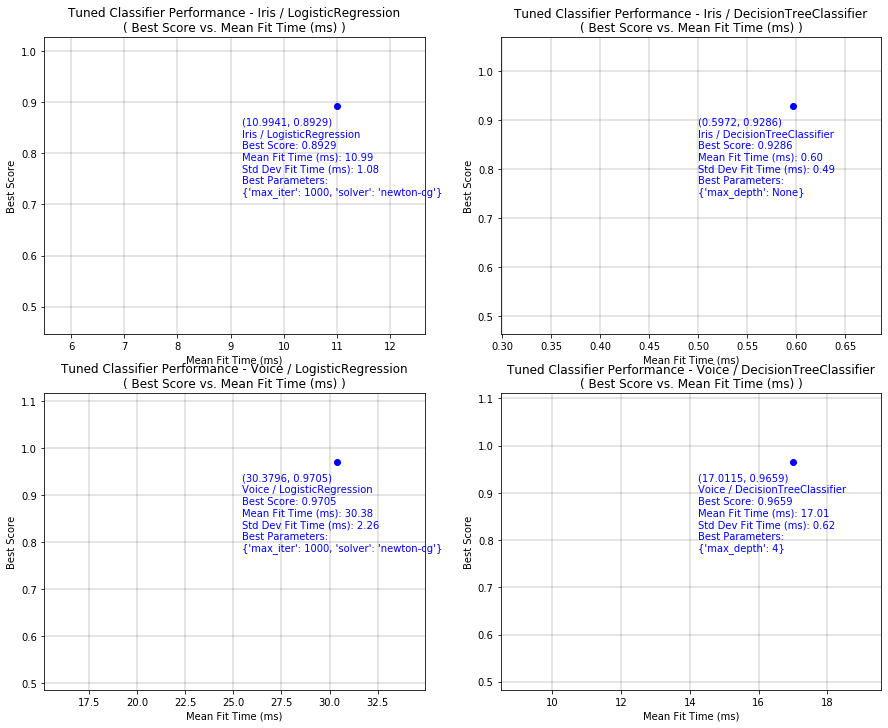

In [32]:
# Plot Classification Performance results
fig1 = plt.figure(figsize=(15,12))

# Create subplots for each Dataset/Classifier combination
ds_list = summary_df['Dataset'].unique()
cls_list = summary_df['Classifier'].unique()

# Create subplots for (# Dataset) columns x (# Classifier) rows
ax_list = []
i_plot = 0
for i_ds in range(len(ds_list)):
    for i_cls in range(len(cls_list)):
        
        # Create the subplot axis and append it to the list of plots
        # Rows: Classifiers, Columns: Datasets
        # Position of a Plot: (Classifier index) * (size of row) + (Dataset index) + 1        
        # ax_list.append( fig1.add_subplot(len(cls_list), len(ds_list), i_cls*len(ds_list) + i_ds + 1  )

        # REFACTORED: For Position just use (i_plot + 1)
        #             since we're populating these in the proper order anyway
        ax_list.append( fig1.add_subplot( len(cls_list), len(ds_list), i_plot + 1 ) )

        # Get the relevant subset of the dataframe for this subplot
        target_df = summary_df[ (summary_df['Dataset'] == ds_list[i_ds])
                               & (summary_df['Classifier'] == cls_list[i_cls]) ].reset_index(drop=True)

        # Create the plot
        plot_summary(ax_list[i_plot], target_df)

        # Increment the plot counter
        i_plot += 1
        
# Save the image - use it for Summary of Analysis at the top of the notebook
plt.savefig('docs/Figure-Hyper_Parameter_Tuning.png', bbox_inches='tight')

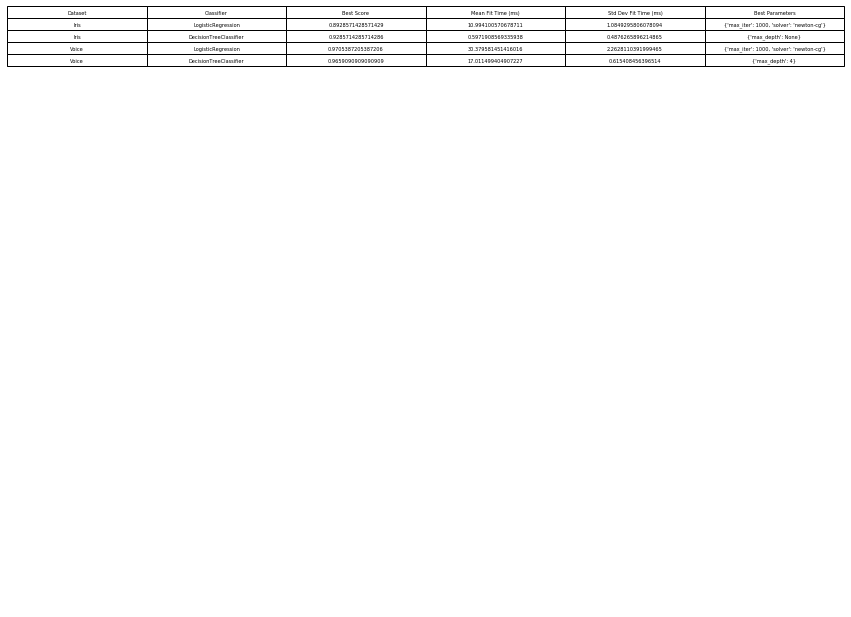

In [33]:
# Table: Performance results
# fig_table_1 = plt.figure(figsize=(15,12))
fig_table_1 = plt.figure(figsize=(15,10))

# Create axes for this table, but with no visible frame
ax_table = fig_table_1.add_subplot(111, frame_on=False)

# Hide the x and y axes
ax_table.xaxis.set_visible(False)
ax_table.yaxis.set_visible(False)

plt.table(cellText=summary_df.values,
#           colWidths = [0.15]*len(summary_df.columns),
#           rowLabels=summary_df.index,
            colLabels=summary_df.columns,
            cellLoc = 'center',
            rowLoc = 'center',
            loc='top')

# Show the resulting table
plt.show()
        
# Save the image - use it for Summary of Analysis at the top of the notebook
fig_table_1.savefig('docs/Table-Hyper_Parameter_Tuning.png', bbox_inches='tight') 